In [ ]:
%pip install torch torchvision pandas numpy matplotlib pillow seaborn opencv-python 
%matplotlib inline

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
import seaborn as sns
from skimage import io 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import skimage
import random 
import numpy as np
import matplotlib.pyplot as plt  

In [ ]:
%pip install keras_preprocessing

In [ ]:
dataset_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images'
annotations_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/annotations'

In [ ]:
# Verify all images have the same size
sizes = []

image_files = sorted([f for f in os.listdir(dataset_pth) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])

for img_file in image_files[:50]:  # Check first 50 images
    img_path = os.path.join(dataset_pth, img_file)
    with Image.open(img_path) as img:
        sizes.append(img.size)

unique_sizes = set(sizes)
print(f"Unique image sizes in sample: {unique_sizes}")
print(f"All images have same size: {len(unique_sizes) == 1}")
print(f"Images Count: {len(sizes)}")

Unique image sizes in sample: {(588, 319), (521, 229), (580, 315), (899, 440), (786, 383), (294, 366), (302, 190), (507, 330), (499, 326), (419, 217), (1275, 696), (833, 351), (719, 329), (625, 322), (537, 209), (591, 329), (851, 405), (503, 216), (583, 325), (1031, 601), (949, 562), (466, 185), (1034, 606), (720, 330), (780, 381), (405, 175), (1098, 627), (804, 329), (529, 210), (782, 390), (1061, 745), (574, 361), (480, 205), (460, 376), (1095, 621), (1035, 607), (532, 215), (706, 288), (525, 212), (892, 414), (444, 287), (685, 350), (1091, 623), (382, 312), (1163, 648), (499, 339), (446, 333), (875, 330), (1267, 705), (457, 342), (423, 200), (610, 292), (784, 328), (607, 286), (426, 211), (1012, 600), (442, 335), (1271, 711), (457, 198), (871, 332), (788, 334), (506, 319), (738, 333), (296, 366), (396, 224), (650, 369), (1008, 602), (507, 320), (654, 339), (614, 303), (787, 374), (338, 219), (512, 255), (780, 335), (731, 330), (583, 315), (689, 333), (468, 185), (1256, 709), (516, 2

##### convert annotation xml file to dataframe

In [45]:
#  Parse XML annotations and create DataFrame
def parse_xml_annotation(xml_path):
    """Parse XML file and extract annotations"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Get image info
        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        # Extract objects
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            bbox = {
                'xmin': int(bndbox.find('xmin').text),
                'ymin': int(bndbox.find('ymin').text),
                'xmax': int(bndbox.find('xmax').text),
                'ymax': int(bndbox.find('ymax').text)
            }
            objects.append({'class': name, 'bbox': bbox})
        
        return {
            'filename': filename,
            'width': width,
            'height': height,
            'objects': objects
        }
    except Exception as e:
        print(f"Error parsing {xml_path}: {e}")
        return None

dataset_info = []

# collect xml files from annotations_pth 
xml_files = sorted([f for f in os.listdir(annotations_pth) if f.lower().endswith('.xml')])
if len(xml_files) == 0:
    print(f"Warning: No XML files found in {annotations_pth}")

for xml_file in xml_files:
    xml_path = os.path.join(annotations_pth, xml_file)
    annotation = parse_xml_annotation(xml_path)
    
    if annotation:
        dataset_info.append({
            'image_name': annotation['filename'],
            'image_path': os.path.join(dataset_pth, annotation['filename']),
            'xml_path': xml_path,
            'width': annotation['width'],
            'height': annotation['height'],
            'num_objects': len(annotation['objects']),
            'objects': annotation['objects']
        })

df = pd.DataFrame(dataset_info)
print(f"Created DataFrame with {len(df)} samples")
df.head()
df.tail()

Created DataFrame with 3231 samples


,image_name,image_path,xml_path,width,height,num_objects,objects
3226,\t230.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,784,334,2,"[{'class': 'Normal Flow', 'bbox': {'xmin': 101..."
3227,\t231.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,784,330,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3228,\t232.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,781,330,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3229,\t233.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,788,326,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."
3230,\t234.png,C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...,C:/MAMP/htdocs/2025_GP_27/model1/annotations\n...,780,328,1,"[{'class': 'Normal Pressure', 'bbox': {'xmin':..."


In [ ]:
# Analyze ALL class names from the ENTIRE dataset
print("=== COMPREHENSIVE CLASS ANALYSIS (FULL DATASET) ===")

all_classes = []
class_examples = {}  

for xml_file in xml_files: 
    xml_path = os.path.join(annotations_pth, xml_file)
    annotation = parse_xml_annotation(xml_path)
    
    if annotation:
        for obj in annotation['objects']:
            class_name = obj['class']
            all_classes.append(class_name)
            
            # Store example for this class
            if class_name not in class_examples:
                class_examples[class_name] = {
                    'image_file': annotation['filename'],
                    'bbox': obj['bbox']
                }

#  classes
class_counts = pd.Series(all_classes).value_counts()
print("Complete Class Distribution (Full Dataset):")
print(class_counts)

print(f"\nTotal unique classes: {len(class_counts)}")
print(f"Total annotations: {len(all_classes)}")
print(f"\nExample images for each class: {len(class_examples)}")
print(f"Total XML files processed: {len(xml_files)}")

=== COMPREHENSIVE CLASS ANALYSIS (FULL DATASET) ===
Complete Class Distribution (Full Dataset):
Normal Flow                  849
Normal Volume                687
Accumulation Flow            562
Volume                       562
Premature_cycling Flow       476
Premature_cycling Volume     460
Flow                         452
Leakage Volume               452
Ineffective_effort Volume    438
Ineffective_effort Flow      438
Double_Triggering Volume     424
Double_Triggering Flow       422
Normal Pressure              316
Name: count, dtype: int64

Total unique classes: 13
Total annotations: 6538

Example images for each class: 13
Total XML files processed: 3231


Dataset Overview:
Total images: 3231
Total annotations: 6538

Class Distribution:
Normal Flow                  849
Normal Volume                687
Accumulation Flow            562
Volume                       562
Premature_cycling Flow       476
Premature_cycling Volume     460
Flow                         452
Leakage Volume               452
Ineffective_effort Volume    438
Ineffective_effort Flow      438
Double_Triggering Volume     424
Double_Triggering Flow       422
Normal Pressure              316
Name: count, dtype: int64


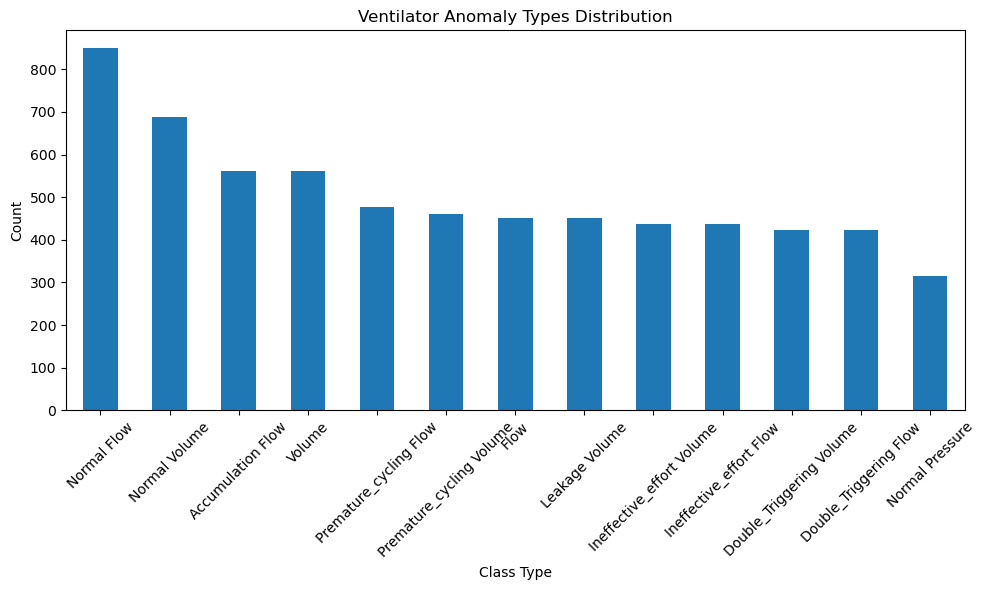

In [48]:
# Explore the dataset
print("Dataset Overview:")
print(f"Total images: {len(df)}")
print(f"Total annotations: {df['num_objects'].sum()}")

all_classes = []
for objects in df['objects']:
    for obj in objects:
        all_classes.append(obj['class'])

class_counts = pd.Series(all_classes).value_counts()
print("\nClass Distribution:")
print(class_counts)

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Ventilator Anomaly Types Distribution')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

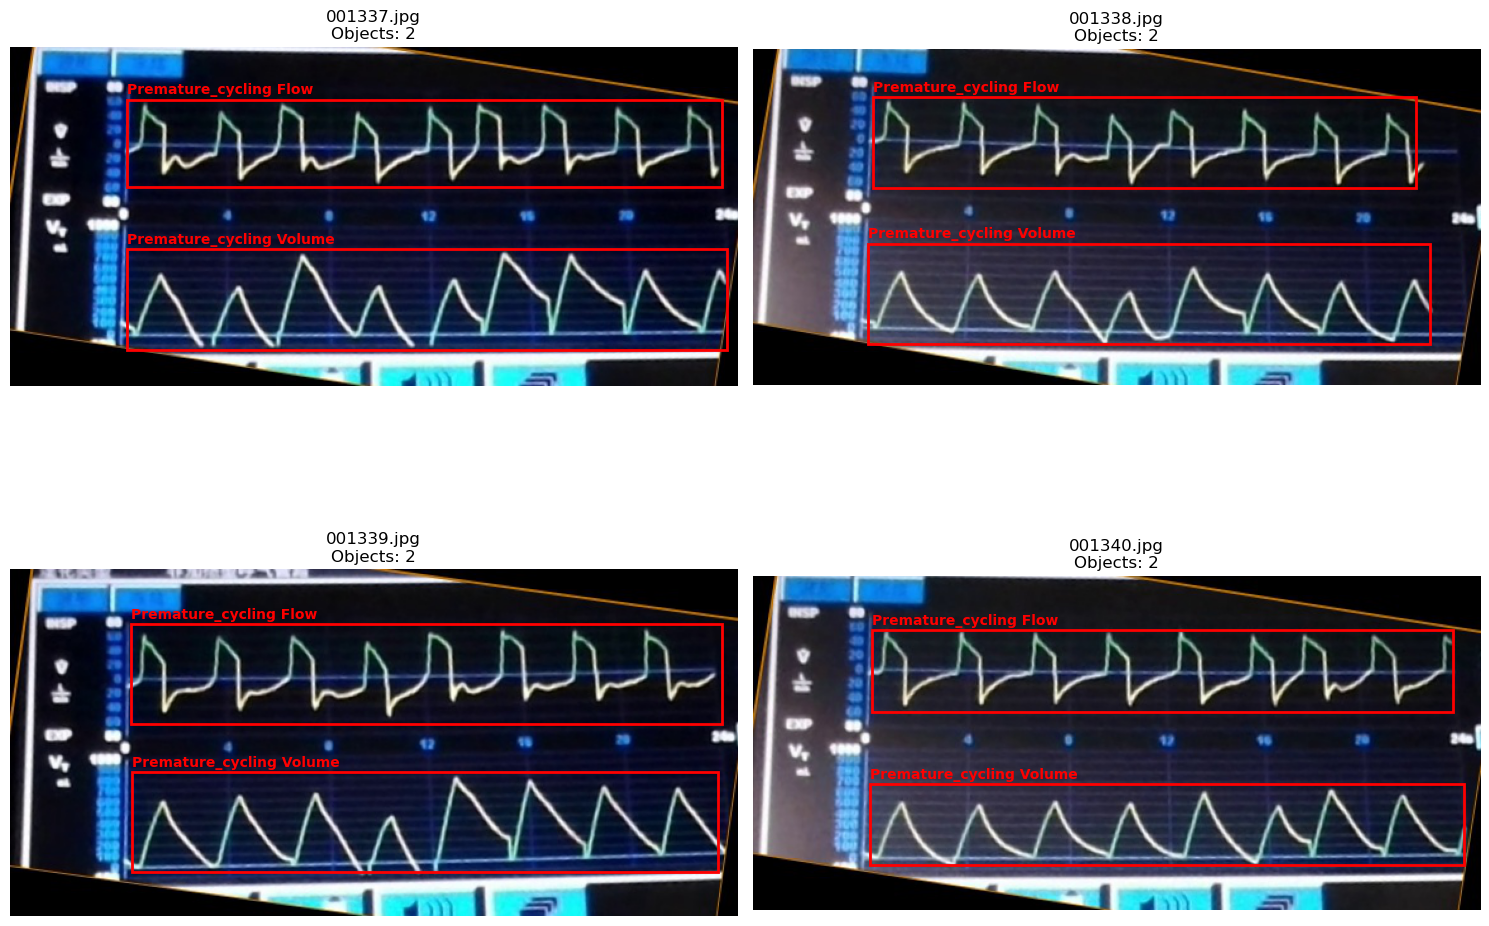

In [61]:
# Visualize samples with bounding boxes
def plot_samples_with_boxes(df, num_samples=4):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (_, row) in enumerate(df.head(num_samples).iterrows()):
        # Load image
        img = Image.open(row['image_path'])
        ax = axes[idx]
        ax.imshow(img)
        ax.set_title(f"{row['image_name']}\nObjects: {row['num_objects']}")
        
        # Draw bounding boxes
        for obj in row['objects']:
            bbox = obj['bbox']
            rect = plt.Rectangle(
                (bbox['xmin'], bbox['ymin']),
                bbox['xmax'] - bbox['xmin'],
                bbox['ymax'] - bbox['ymin'],
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                bbox['xmin'], max(bbox['ymin'] - 5, 0),
                obj.get('class', ''), color='red', fontsize=10, weight='bold'
            )
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Use existing 'target' variable if available; otherwise fallback to example class name
try:
    cls = target
except NameError:
    cls = 'Premature_cycling'

# Build boolean mask: True if any object in the row has the target class
mask = df['objects'].apply(lambda objs: any(o.get('class') == cls or o.get('class', '').startswith(cls) for o in objs))

filtered_df = df[mask]

if not filtered_df.empty:
    plot_samples_with_boxes(filtered_df)
else:
    print(f"No samples found for class '{cls}'")

###Preprocess part??

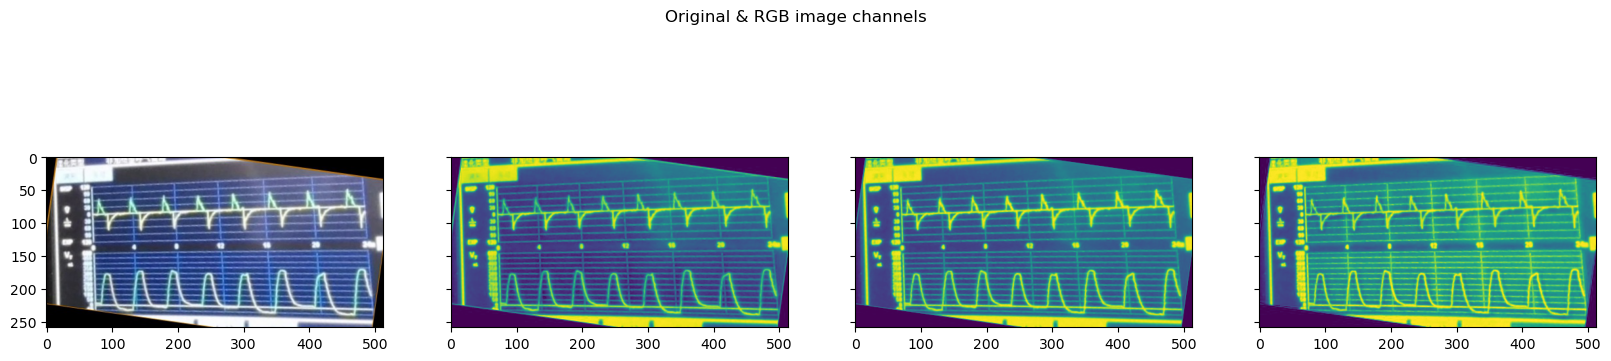

In [63]:
# plotting the original image and the RGB channels  
i, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=True)
i.set_figwidth(20) 

im1.imshow(image)  #Original image
im2.imshow(image[:, : , 0]) #Red
im3.imshow(image[:, : , 1]) #Green
im4.imshow(image[:, : , 2]) #Blue
i.suptitle('Original & RGB image channels')
plt.show()

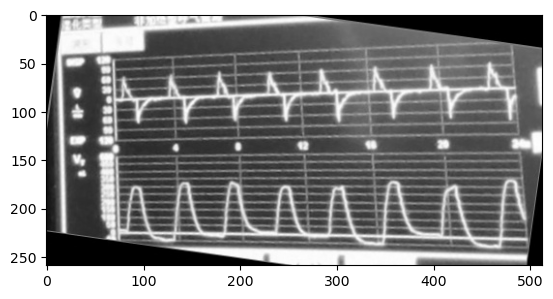

In [64]:
image = io.imread('C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images/000009.jpg')
gray_image = skimage.color.rgb2gray(image)
plt.imshow(gray_image, cmap = 'gray')
plt.show()

##### preprocessing through grayscale conversion, Normalisation, Data Augmentation, Image standardization


In [ ]:
norm_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
plt.imshow(norm_image)
plt.show()

In [ ]:
from numpy import expand_dims
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import ImageDataGenerator

# convert to numpy array
data = img_to_array(image)

# expand dimension to one sample
samples = expand_dims(image, 0)

# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=[-200,200])

# create an iterator
it = datagen.flow(samples, batch_size=1)
fig, im = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

    # convert to unsigned integers
    images = next(it)[0].astype('uint8')
 
    # plot image
    im[i].imshow(images) 